# Loading the data

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import sys
import glob
import pandas as pd
from pathlib import Path


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [2]:
CV_TYPE = 'loco'

model_name = 'ProjNetMerged4'
filepaths = glob.glob('/media/brainstimmaps/DATA/2009_DeepMaps01/04_Source/01_Development/deepmaps/'
    f'models/predict_{CV_TYPE}/{model_name}/perf/*')

filepaths.sort()
filepath = filepaths[-1]
print(filepath.split('/')[-1])

center_colors = {
    'Bern' : '#d7191c',
    'Cologne' : '#2c7bb6',
    'All' : '#5e3c99'
}
#filepath = '/media/brainstimmaps/DATA/2009_DeepMaps01/04_Source/01_Development/deepmaps/data/processed/stn_space_3sigma_subtracted/merged/flipped/tables_tweened/250um.csv'

df = pd.read_csv(filepath)


23.09.28.15:54:57.csv


In [13]:
import pandas as pd

# Your dataframe
# df = pd.read_csv('your_data.csv')

def set_full_effect(group):
    # Initialize the 'full_effect' column to 'unknown'
    group['full_effect'] = 'unknown'
    
    # Filter out rows where 'noisy' is True
    filtered_group = group[group['noisy'] == False]
    
    # Check if there is a mapping_score of 1 in the filtered group
    if 1 in filtered_group['mapping_score'].values:
        # Get the amplitude corresponding to the mapping_score of 1
        amplitude_at_1 = filtered_group.loc[filtered_group['mapping_score'] == 1, 'amplitude'].iloc[0]
        
        # Set 'full_effect' or 'partial_effect' based on the condition
        group.loc[group['noisy'] == False, 'full_effect'] = filtered_group['amplitude'].apply(
            lambda x: 'full_effect' if x >= amplitude_at_1 else 'partial_effect'
        )
    
    return group

# Initialize 'full_effect' to 'unknown' for rows where 'noisy' is True
df.loc[df['noisy'] == True, 'full_effect'] = 'unknown'

# Group by 'patientID' and 'verciseID' and apply the function
df = df.groupby(['patient', 'vercise']).apply(set_full_effect).reset_index(drop=True)


In [14]:
df['full_effect'].value_counts()

full_effect
unknown           573336
full_effect        10413
partial_effect      7299
Name: count, dtype: int64

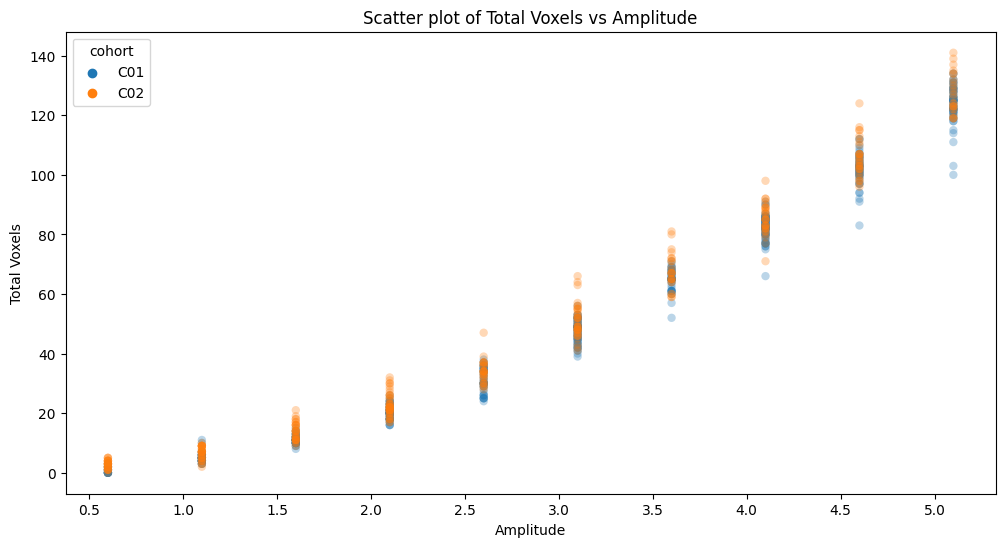

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df and center_colors are already defined

# Create a copy of the DataFrame to avoid modifying the original one
filter_df = df[(df['noisy'] == False) & (df['tweening'] == False) & (df['center'] == 'Cologne')].copy()
#filter_df = df[(df['tweening'] == False) & (df['center'] == 'Cologne')].copy()


cohort_colors = {
    'Bern': '#d7191c',
    'B01': '#e0292b',
    'B02': '#c60f17',
    'Cologne': '#2c7bb6',
    'C01': '#3c8bc7',
    'C02': '#1c6aa5'
}


# Add a new column for the adjusted amplitude
delta_x = 0.1
filter_df['adjusted_amplitude'] = filter_df.apply(lambda row: row['amplitude'] - delta_x if row['center'] == 'Bern' else (row['amplitude'] + delta_x if row['center'] == 'Cologne' else row['amplitude']), axis=1)

# Scatter plot for 'total_voxels' vs 'adjusted_amplitude' colored by 'centerID'
plt.figure(figsize=(12, 6))
sns.scatterplot(data=filter_df, x='adjusted_amplitude', y='total_voxels', hue='cohort', alpha=.3, edgecolor='none')

plt.title("Scatter plot of Total Voxels vs Amplitude")
plt.xlabel('Amplitude')
plt.ylabel('Total Voxels')

plt.xticks(np.arange(min(filter_df['adjusted_amplitude'])-0.1, max(filter_df['adjusted_amplitude'])-0.1 + 0.5, 0.5))

plt.show()


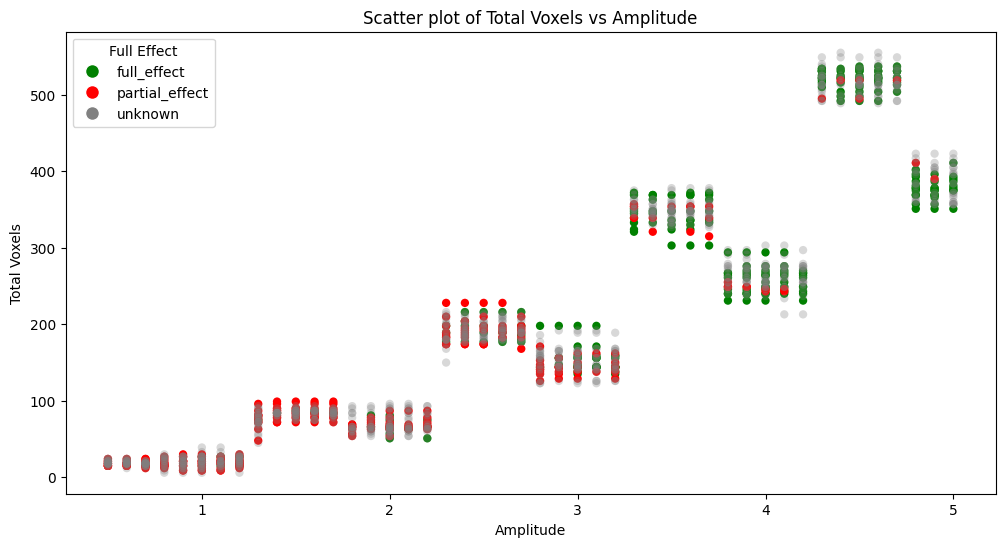

In [9]:
plt.figure(figsize=(12, 6))

color_palette = {
    'full_effect': 'green',
    'partial_effect': 'red',
    'unknown': 'gray'
}

effect_hues = {
    'full_effect': 1,
    'partial_effect': 1,
    'unknown': 0.3
}

# Filter DataFrame based on other conditions
df_c = df[(df['noisy'] == False) & 
          (df['lead_model'] == 'B.S. Vercise') & 
          (df['center'] == 'Cologne')]

# Loop through each full_effect and plot with custom alpha
for effect, alpha in effect_hues.items():
    sub_df = df_c[df_c['full_effect'] == effect]
    plt.scatter(sub_df['amplitude'], sub_df['total_voxels'], color=color_palette[effect], alpha=alpha, edgecolor='none')

plt.title("Scatter plot of Total Voxels vs Amplitude")
plt.xlabel('Amplitude')
plt.ylabel('Total Voxels')

# Add legend manually to match colors and labels
plt.legend(title='Full Effect', labels=color_palette.keys(), handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in color_palette.values()])

plt.show()
